In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

import time

# Это домашка на 5 баллов
## Остальные 5 баллов за домашку будут на word2vec (следующее занятие)

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Не стоит пока об этом задумываться, это просто нормализация для картинок

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

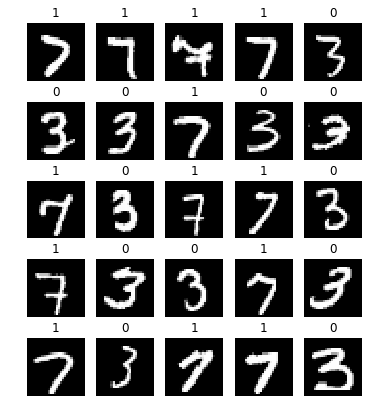

In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Пояснения
### классу 0 соответствует цифра 3
### классу 1 соответствует цифра 7
#### Выбрал эти цифры, потому что на них хуже всего метрики

# Итерация по датасету
# А вот сюда стоит обратить внимание

In [7]:
for x, y in train_loader:
    break

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [8]:
x.shape

torch.Size([128, 1, 28, 28])

In [9]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### Для нашей игрушечной задачи для поучиться будет достаточно

In [10]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

In [11]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [12]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [13]:
x.shape

(128, 784)

# Наши бинарные таргеты

In [14]:
y

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [15]:
# ошибка это нормально
x * y

ValueError: operands could not be broadcast together with shapes (128,784) (128,) 

In [16]:
# давайте ее исправим

In [17]:
y = np.expand_dims(y, 1)

In [18]:
y

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
    

In [19]:
x * y

array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]])

In [20]:
# исправили

# Итерация по эпохам

In [21]:
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными, например, учить, но пока этого делать не будет
        
        time.sleep(0.05)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Давайте поучим пока не очень красиво нашу 2-х слойную нейронку

## 3 балла

### Шаги:
0. Задайте обучаемые параметры (TIP: np.random.rand) и скорость обучения для градиентного спуска.
1. Линейная трансформация через первый слой
1. Применение какой-нибудь нелийной функции активации
1. Линейная трансформация через второй слой
1. Примените какую-нибудь функцию, которая хорошая для бинарной классификации, чтобы перейти к вероятностям классов
1. Рассчитайте функцию потерь (бинарная кросс энтропия), не забудьте усреднить по батчу
1. Возьмите производные от функции потерь к каждому обучаемому параметру [видео про производные](https://youtu.be/tZ0yCzWfbZc)
1. Обновите веса w1, b1, w2, b2 с помощью градиентного спуска
1. Сохраняйте значения функции потерь и нарисуйте ее график

- TIP: количество входных фичей - 784 (28 пикселей * 28 пикселей)
- TIP: в шаге 0 домножьте w1, w2 на 0.01, а b1, b2 инициализируйте нулями
- TIP: в backward функции потерь по предсказаниям вашей модели нужно разделить еще на количество примеров в батче
- TIP: каждый следующий градиент рассчитывайте умножая на предыдущий

## Если вам сложно, сделайте сначала для одного слоя

In [22]:
### КОД СЮДА ###

# learning_rate = 
# epochs = 

# w1 = 
# b1 = 
# w2 = 
# b2 = 

losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        ### КОД СЮДА ###
        
        # forward
        
        # рассчет bce
        
        # backward
        
        # gradient descent

Epoch: 1
Epoch: 2
Epoch: 3


# Значение функции потерь на уровне 0.1 это уже выше 90% точности

Text(0, 0.5, 'Loss function')

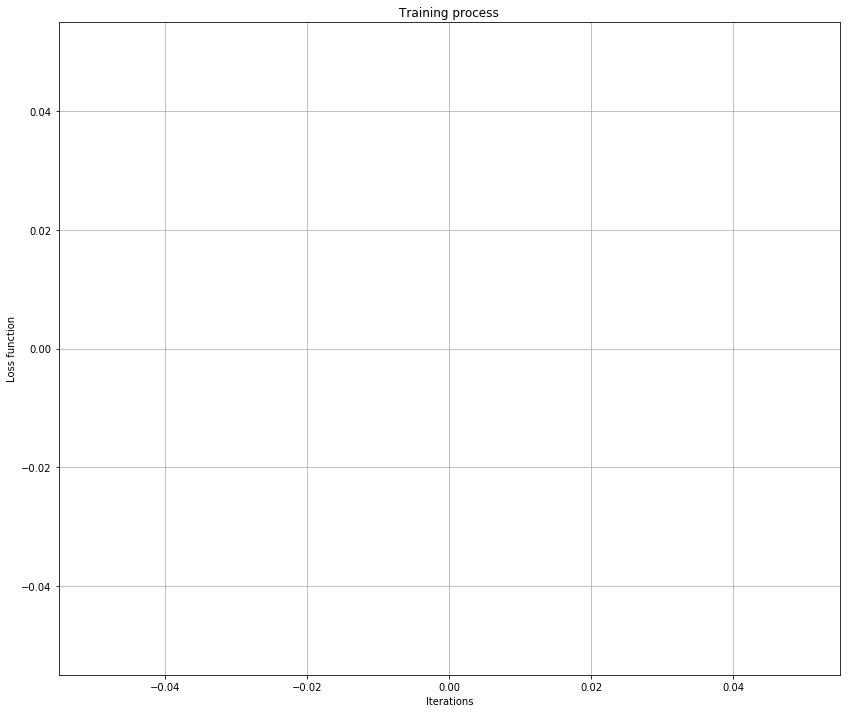

In [23]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

# По крутому

## 2 балл

# Импортируем нашу библиотеку

In [24]:
from our_library import layers, wrapper, tools

# Пример, который мы разбирали в [видео про производные](https://youtu.be/tZ0yCzWfbZc)

In [25]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):

        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """

        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_step):

        pass

## Также внутри layers есть код для Negative Log-Lilehood с софтмаксом

## Реализуйте такие слои:
- Linear - линейная трансформация (не забудьте, что у нас там как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, )

## Загатовка

In [26]:
class ReLU:

    def __init__(self):
        
        pass

    def forward(self, x):

        pass

    def backward(self, grad):

        pass

    def step(self, learning_rate):

        pass

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше
- TIP 2: циклы это круто
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: Посмотрите какие особенности реализации NLLLoss

In [27]:
class NeuralNetwork:

    def __init__(self, modules):

        # список слоев
        self.modules = modules

    def forward(self, x):

        pass

    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """

        pass

    def step(self, learning_rate):

        pass

## Реализуйте обертку над моделью

In [28]:
class MNISTWrapper(wrapper.Wrapper):

    def __init__(self, model, loss, learning_rate=0.001, multi_class=False):

        # передаем параметры, чтобы отработал __init__ от наследуемого класса
        # можно было бы сделать через **kwargs, но сделал так для наглядности и чтобы были подсказки в юпитере

        super().__init__(model=model, loss=loss, learning_rate=learning_rate, multi_class=multi_class)

    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели
        5. Обновление весов
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """

    def predict_batch(self, x):
        """
        Предсказание (aka inference) вашей модели:
        1. Рассчет forward
        :param x: входные данные np.array with shape (batch_size, n_features)
        :return: prediction - матрица предсказаний вашей модели
        """

In [29]:
# задайте гиперпараметры
# learning_rate = 
# epochs = 

# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = layers.NeuralNetwork([])

loss = layers.BCELoss()

In [30]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)

NameError: name 'learning_rate' is not defined

## Раскомментируйте и запустите

In [ ]:
# classifier.train(train_loader, test_loader, epochs=epochs)

In [ ]:
# classifier.plot()